# Traffic Sign Recognition
----

Progetto del corso di Machine Learning AA 2017/2018

Corso di Laurea Magistrale in Informatica, Università di Bologna

- Ceccolini Enrico (matricola )
- Valguarnera Enrico (800115)


Il progetto consiste nell'analisi ed implementazione di alcune delle soluzioni presentate nel paper *Traffic Sign Recognition with Multi-Scale Convolutional Networks* redatto da Pierre Sermanet e Yann LeCun. Tale studio racchiude le tecniche principali avanzate da diversi team di ricercatori (tra cui il loro) durante le competizioni IJCNN, sfide che avevano come obiettivo la realizzazione del miglior classificatore di segnali stradali (single-image, multi-class classification problem) partendo dal dataset GTSRB, dataset che impareremo a conoscere.

E' possibile reperire il paper [qui]('http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf').

In particolare si cercherà di aderire alle tecniche proposte di: aumento del dataset, normalizzazione del dataset e di definizione delle reti neurali, proponendo alcune modifiche o integrazioni per il miglioramento dei modelli risultanti. 

# 1) Il Dataset GTSRB
---

Per uniformità al paper è stato scelto di utilizzare la versione del dataset indicata per l'*online competition stage*, non l'ultima presentata dall'istituto che si occupa delle competizioni. 

E' possibile ottenere il dataset [qui]('http://benchmark.ini.rub.de/index.php?section=gtsrb&subsection=dataset#Downloads').

Questa contiene 39209 immagini in totale, divise tra tra training-set (26,640 immagini) e test-set (12,569 immagini). Ogni immagine contiene un singolo segnale stradale appartenente ad una delle 43 classi presenti. Le dimensioni delle immagini variano da un minimo di 15x15 ad un massimo di 250x250 pixel.

Le immagini contenute nel dataset presentano molteplici difficoltà, per rispecchiare al meglio i problemi che si presentano nel mondo reale: diversi punti di vista, condizioni di luce (irradiazione, saturazione e basso contrasto), sfocature dovute al movimento, danni fisici, graffiti, adesivi e bassa risoluzione.

Load del dataset

In [1]:
import my_mod_load as load # modulo per il load del dataset

train, valid, test = load.load_train_valid_test()

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

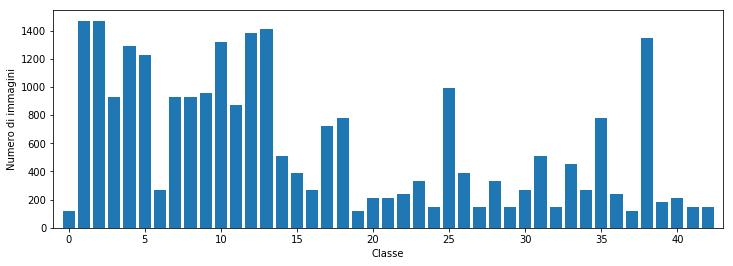

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)

plt.figure(figsize=(12, 4))
plt.bar(np.arange(43), class_counts, align='center')
plt.xlabel('Classe')
plt.ylabel('Numero di immagini')
plt.xlim(-1, 43)
plt.show()

----- TODO: parlare del ritaglio delle immagini?

Visualizzazione di alcune immagini

In [3]:
# valori? grafici? (alcuni solo visualizzazione caricando immagini)

# 2) Data Preparation
---
## 2.1) Validation

Come evdenzia il paper, la selezione delle immagini che popoleranno il validation dataset è cruciale in GTSRB. Mischiare le immagini e selezionare un sottoinsieme porterebbe ad avere un validation dataset troppo simile al training dataset e all'impossibilità di ottenere valori di performance del modello accurati.

Il motivo è da trovare nella tecnica utilizzata per ottenere le immagini del dataset. Le immagini sono state estratte da tracce video. Per ogni traccia il segnale stradale presente è stato catturato circa 30 volte con aumento progressivo della risuluzione a mano a mano che la videocamera si avvicinava al segnale.

Per la definizione del validation set si è estratta in maniera casuale una traccia per ognuna delle 43 classi, in modo da non avere immagini dello stesso identico segnale stradale nei diversi insiemi.

In [4]:
print("Dimensione del training-set: {}".format(len(X_train)))
print("Dimensione del valid-set: {}".format(len(X_valid)))

Dimensione del training-set: 25350
Dimensione del valid-set: 1290


## 2.2) Pre-processing
---
Per la fase di pre-processing è stata definita una collezione di funzioni, presente nel file my_mod_manipulate_image.py, utile per la normalizzazione e l'aumento dei dati.

### 2.2.1) Normalization
---
Di seguito la funzione di normalizzazione per una immagine in input.

``` Python
def normalize_img(img):
    
    img_y = cv2.cvtColor(img, (cv2.COLOR_BGR2YUV))[:,:,0] #converte l'immagine in YUV e tiene il canale Y
    img_y = cv2.equalizeHist(img_y) # Equalizzazione globale
    img_y = (img_y / 255.).astype(np.float32) # Rappresenta i valori in un range di [0-1]
    img_y = (exposure.equalize_adapthist(img_y) - 0.5) # Equalizzazione locale
    img_y = img_y.reshape(img_y.shape + (1,))

    return img_y
```

Normalizzazione delle immagini contenute nel training set

```Python
import my_mod_manipulate_image as manipulate # normalizzazione e aumento dei dati

X_train_norm = list()
y_train_norm = list()

for ii in range(int(len(X_train)/1000)):
    img = X_train[ii]
    label = y_train[ii]
    imgout = manipulate.normalize_img(img)
    X_train_norm.append(imgout)
    y_train_norm.append(label)
```


Visualizzazione di alcune immagini normalizzate

In [5]:
#TODO : visualizzazione di alcune immagini normalizzate ?!

### 2.2.2) Jittering
---
Per l'aumento dei dati è stata utilizzata la libreria Keras. In particolare tramite il modulo ImageDataGeneration è stato possibile generare l'aumento dei dati. Nel ciclo for sottostante è riportata la generazione di un nuovo insieme di immagini delle stesse dimensioni del training set originario.

(TODO : spiegare meglio) 

```Python
datagen = ImageDataGenerator(
        # perturbed in position ([-2, 2] pixels)
        width_shift_range=0.1,
        height_shift_range=0.1,
        # perturbed in scale ([.9, 1.1] ratio)
        #rescale=1./255,
        # perturbed in rotation ([-15, 15] degrees)
        rotation_range=15,
        shear_range=0.3,
        zoom_range=0.15,
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='nearest')

# TODO aggiungere fattore moltiplicativo (esguendo più cicli?)
# i cicli 2 e 3 creano immagini diverse dal primo?
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=len(X_train)):
    X_train_aug = X_batch.astype('uint8')
    y_train_aug = y_batch
    break

```

Load del dataset manipolato

Dimensione del training-set: 152100


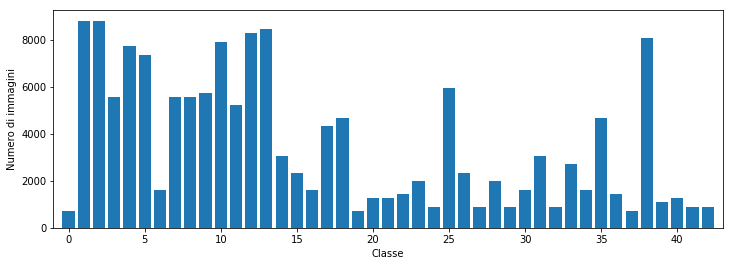

In [8]:
dirname = '2018-02-06_1645_online_augm_blur'

X_train, y_train = load.load_manipulated_train(dirname)
X_valid, y_valid = load.load_normalized_valid(dirname)
X_test, y_test = load.load_normalized_test(dirname)
print("Dimensione del training-set: {}".format(len(X_train)))

sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)

plt.figure(figsize=(12, 4))
plt.bar(np.arange(43), class_counts, align='center')
plt.xlabel('Classe')
plt.ylabel('Numero di immagini')
plt.xlim(-1, 43)
plt.show()

Visualizzazione di alcune immagini

## 3) Architecture
---

## 4) Experiments
---

## 5) Test sulle nuove immagini
---

/Miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


(6, 32, 32, 1)
(32, 32, 1)


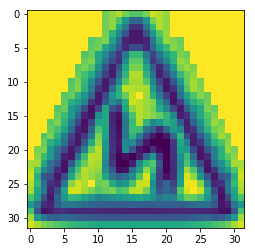

In [7]:
import matplotlib.pyplot as plt
new_images = load.load_new_data()
print(new_images.shape)

img = new_images[0]
print(img.shape)
plt.imshow(img[:,:,0])


## Bibliografia

[\[1\] GTSRB - Man vs. computer: Benchmarking machine learning algorithms for traffic sign recognition]('http://dx.doi.org/10.1016/j.neunet.2012.02.016')